In [1]:
!pip install swifter

In [2]:
!pip install emoji

In [3]:
conda install -c anaconda nltk


usage: conda [-h] [-V] command ...
conda: error: unrecognized arguments: nltk

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install gensim


Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
import swifter

#One-hot encodding
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt

import emoji
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from gensim.models import KeyedVectors


# We are going to merge three datasets together : Getting_Real_about_Fake_News(big data), True, Fake.

#  **EDA**

# **Getting_Real_about_Fake_News(big data-train).csv**

In [95]:
df_fakenews = pd.read_csv("Getting_Real_about_Fake_News(big data—train).csv")
df_fakenews.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [96]:
df_fakenews.columns

Index(['uuid', 'ord_in_thread', 'author', 'published', 'title', 'text',
       'language', 'crawled', 'site_url', 'country', 'domain_rank',
       'thread_title', 'spam_score', 'main_img_url', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'type'],
      dtype='object')

In [97]:
df_fakenews.shape

(12999, 20)

In [98]:
df_fakenews["type"].value_counts()

bs            11492
bias            443
conspiracy      430
hate            246
satire          146
state           121
junksci         102
fake             19
Name: type, dtype: int64

"Data sources that were missing a label were simply assigned a label of "bs". There are (ostensibly) no genuine, reliable, or trustworthy news sources represented in this dataset (so far), so don't trust anything you read."

So we will drop the data labeled as "bs".



In [99]:
df_fakenews = df_fakenews[df_fakenews["type"] != "bs"]
df_fakenews["type"].value_counts()

bias          443
conspiracy    430
hate          246
satire        146
state         121
junksci       102
fake           19
Name: type, dtype: int64

<AxesSubplot: title={'center': 'Number of articles by type'}, xlabel='type'>

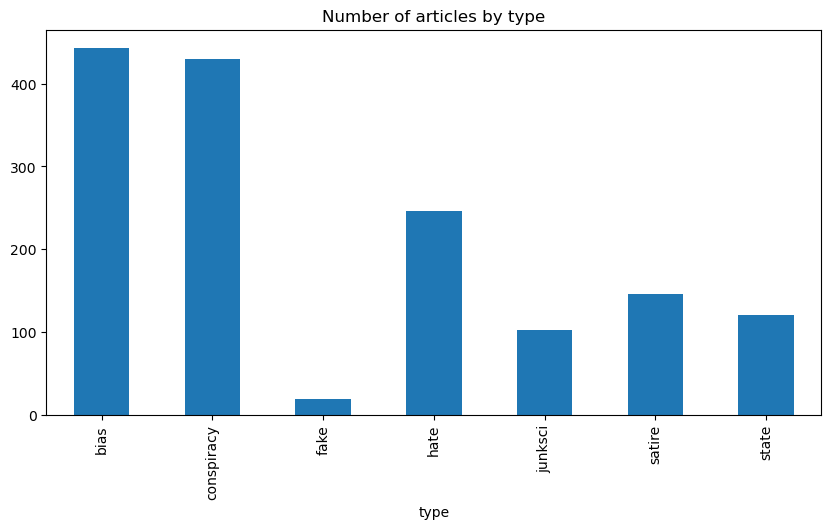

In [100]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
df_fakenews.groupby("type")['type'].count().plot.bar(title = "Number of articles by type", ax = ax)

In [101]:
df_fakenews["language"].value_counts()

english    1503
ignore        3
french        1
Name: language, dtype: int64

We drop data that is not written in english

In [102]:
df_fakenews = df_fakenews[df_fakenews["language"] == "english"]

In [103]:
df_fakenews = df_fakenews[["title", "text", "type"]]

In [104]:
df_fakenews.head()

,title,text,type
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,bias
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,bias
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,bias
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,bias
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,bias


types with "conspiracy", "hate", "satire", "state", "junksci" are all labeled as "fake"

In [105]:
df_fakenews["type"].replace("conspiracy", "fake", inplace=True)
df_fakenews["type"].replace("hate", "fake", inplace=True)
df_fakenews["type"].replace("satire", "fake", inplace=True)
df_fakenews["type"].replace("state", "fake", inplace=True)
df_fakenews["type"].replace("junksci", "fake", inplace=True)

In [106]:
df_fakenews["type"].value_counts()

fake    1060
bias     443
Name: type, dtype: int64

<AxesSubplot: title={'center': 'Number of articles by type'}, xlabel='type'>

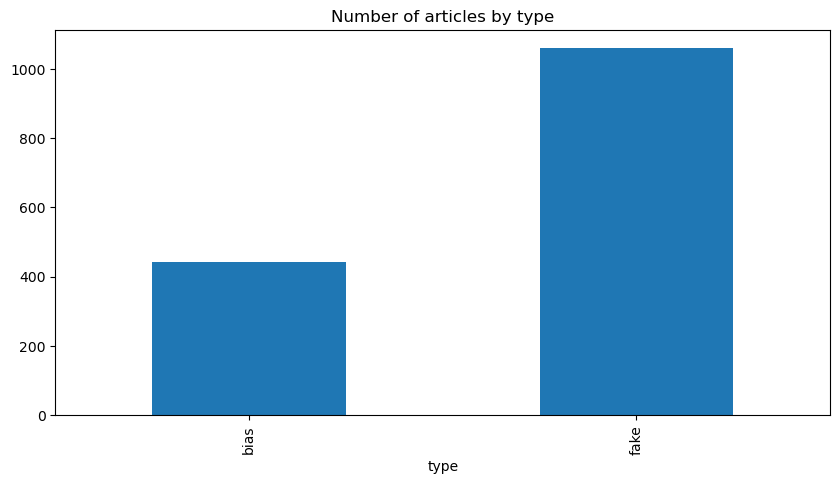

In [107]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
df_fakenews.groupby("type")['type'].count().plot.bar(title = "Number of articles by type", ax = ax)

# **Fake.csv**

In [108]:
df_onlyfake = pd.read_csv("Fake.csv")

In [109]:
df_onlyfake.shape

(23481, 4)

In [110]:
df_onlyfake["type"] = "fake"
df_onlyfake.head()

,title,text,subject,date,type
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [111]:
df_onlyfake = df_onlyfake[["title", "text", "type"]]
df_onlyfake.head()

,title,text,type
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,fake


# **True.csv**

In [112]:
df_onlytrue = pd.read_csv("True.csv")
df_onlytrue.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [113]:
df_onlytrue["type"] = "true"
df_onlytrue = df_onlytrue[["title", "text", "type"]]
df_onlytrue.head()

,title,text,type
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,true
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,true
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,true


# Merge three datasets

In [114]:
# https://www.skytowner.com/explore/concatenating_dataframes_vertically_in_pandas_dataframe

df_news = pd.concat([df_fakenews, df_onlyfake, df_onlytrue], ignore_index=True)
df_news

,title,text,type
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,bias
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,bias
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,bias
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,bias
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,bias
...,...,...,...
46396,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,true
46397,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",true
46398,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,true
46399,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,true


In [115]:
df_news["type"].value_counts()

fake    24541
true    21417
bias      443
Name: type, dtype: int64

<AxesSubplot: title={'center': 'Number of articles by type'}, xlabel='type'>

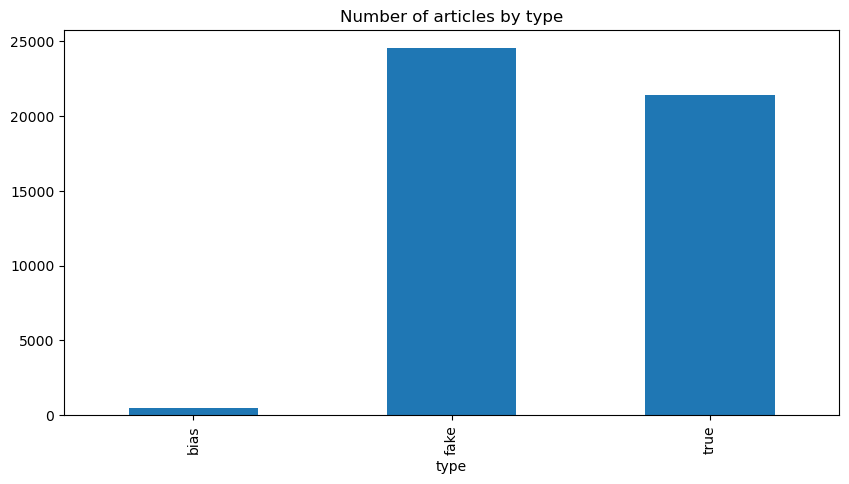

In [116]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
df_news.groupby("type")['type'].count().plot.bar(title = "Number of articles by type", ax = ax)

# - **Data Preprocessing**

The following websites introduces how to do Text Preprocessing.<br>
https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/ <br>
https://www.analyticsvidhya.com/blog/2023/02/tackling-fake-news-with-machine-learning/

# Lowering the Text, Removing Punctuation and Digits, Removing Stop Words

In [117]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [118]:
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://pythonspot.com/nltk-stop-words/

In [119]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tongzhaoliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tongzhaoliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [120]:
# Load the pre-trained word vectors
model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",
                                          binary=True, limit=50000)

In [121]:
embed_mat = np.zeros((50000,300))
for i in model.index_to_key:
    embed_mat[model.key_to_index[i]] = model[i]


In [122]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # checks if the input text is a float.
    # If it is, the function returns an empty string. Otherwise, it proceeds with the preprocessing steps.
    if isinstance(text, float):
        return ''

    # Lowercase the text
    text = str(text).lower()

    # Remove emojis
    text = emoji.demojize(text)
    text = text.replace(":", "")

    # Remove punctuation and digits
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Filter words based on KeyedVectors model vocabulary
    words = [word for word in words if word in model.key_to_index]

    # Join the words back into a string
    text = ' '.join(words)

    return text


In [123]:
# Apply preprocessing to the 'text' column
df_news['clean_text'] = df_news['text'].apply(preprocess_text)

In [124]:
# Apply preprocessing to the 'title' column
df_news['title'] = df_news['title'].apply(preprocess_text)

In [125]:
df_news.head()

,title,text,type,clean_text
0,busted stole millions gov benefits,Print They should pay all the back all the mon...,bias,print pay back money plus interest entire fami...
1,attorney general plead fifth,Why Did Attorney General Loretta Lynch Plead T...,bias,attorney general plead fifth brigade print adm...
2,breaking cooperating email investigation,Red State : \nFox News Sunday reported this mo...,bias,red state fox news reported morning cooperatin...
3,pin drop speech father daughter kidnapped kill...,Email Kayla Mueller was a prisoner and torture...,bias,email prisoner tortured chance horrific story ...
4,fantastic trumps point plan reform healthcare ...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,bias,email healthcare reform make great since march...


## Most common 10 words for every type content(fake, true, bias)

In [126]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [127]:
# most common 20 words in fake content
corpus_text = [preprocess_text(i).split() for i in df_news[df_news['type'] == 'fake']['clean_text'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words]
c = Counter(corpus_text)
most_common_fake_content = c.most_common(20)

# most common 20 words in true content
corpus_text = [preprocess_text(i).split() for i in df_news[df_news['type'] == 'true']['clean_text'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words]
c = Counter(corpus_text)
most_common_true_content = c.most_common(20)

# most common 20 words in bias content
corpus_text = [preprocess_text(i).split() for i in df_news[df_news['type'] == 'bias']['clean_text'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words]
c = Counter(corpus_text)
most_common_bias_content = c.most_common(20)





In [128]:
print('Fake news content - most common words:')
for word, count in most_common_fake_content:
    print(f'{word}: {count}')

print('\nTrue news content - most common words:')
for word, count in most_common_true_content:
    print(f'{word}: {count}')

print('\nBias news content - most common words:')
for word, count in most_common_bias_content:
    print(f'{word}: {count}')

Fake news content - most common words:
trump: 75260
said: 32009
people: 27208
president: 26165
would: 24512
one: 24260
us: 23204
like: 18504
also: 16262
new: 14829
news: 14562
even: 14494
time: 13426
state: 13195
white: 13119
media: 11579
get: 11356
via: 11322
campaign: 11079
house: 10859

True news content - most common words:
said: 99042
trump: 54268
us: 41154
would: 31525
president: 26454
state: 19766
government: 18317
new: 16786
states: 16630
house: 16548
also: 15953
united: 15574
republican: 15348
people: 15255
told: 14244
could: 13710
one: 12703
last: 12614
party: 12457
two: 11624

Bias news content - most common words:
trump: 1516
said: 491
election: 395
one: 345
would: 344
campaign: 338
people: 332
new: 259
president: 257
also: 239
like: 230
republican: 228
voters: 226
news: 225
us: 221
media: 212
time: 207
even: 202
vote: 198
republicans: 194


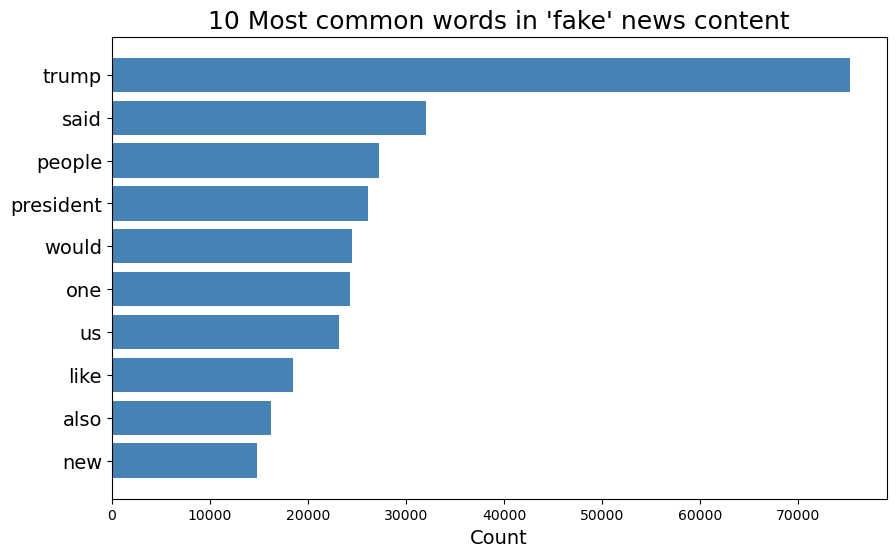

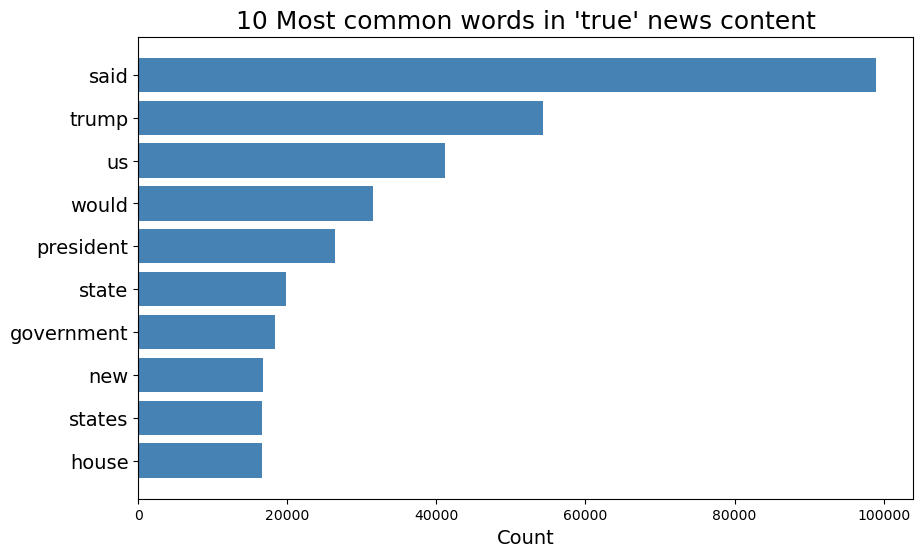

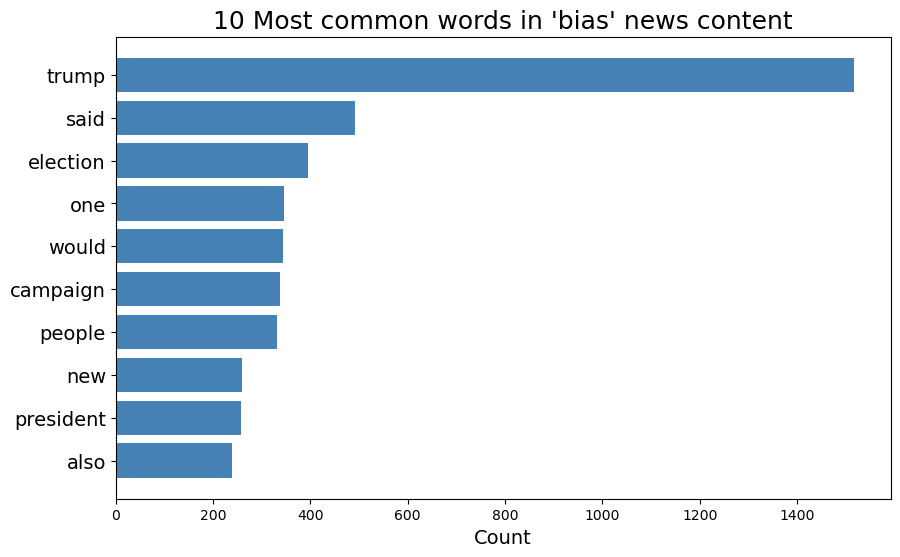

In [129]:
import matplotlib.pyplot as plt

# Define titles and variables for each type of news content
names = ["10 Most common words in 'fake' news content", "10 Most common words in 'true' news content", "10 Most common words in 'bias' news content"]
variables = [most_common_fake_content, most_common_true_content, most_common_bias_content]

# Generate a chart for each type of news content
for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(10,6))

    words = [item[0] for item in var[:10]] # Extract the top 10 most common words
    counts = [item[1] for item in var[:10]] # Extract the counts of the top 10 most common words

    ax.barh(words, counts, color='steelblue') # Create a bar chart
    ax.invert_yaxis() # Invert the y-axis, so the most common word is on top
    plt.tick_params(axis='y', which='major', labelsize=14) # Set the y-axis tick size
    plt.title(title, fontsize=18) # Set the chart title and size
    plt.xlabel('Count', fontsize=14) # Set the x-axis label and size
    plt.show() # Display the chart


# **WordCloud**

In [130]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


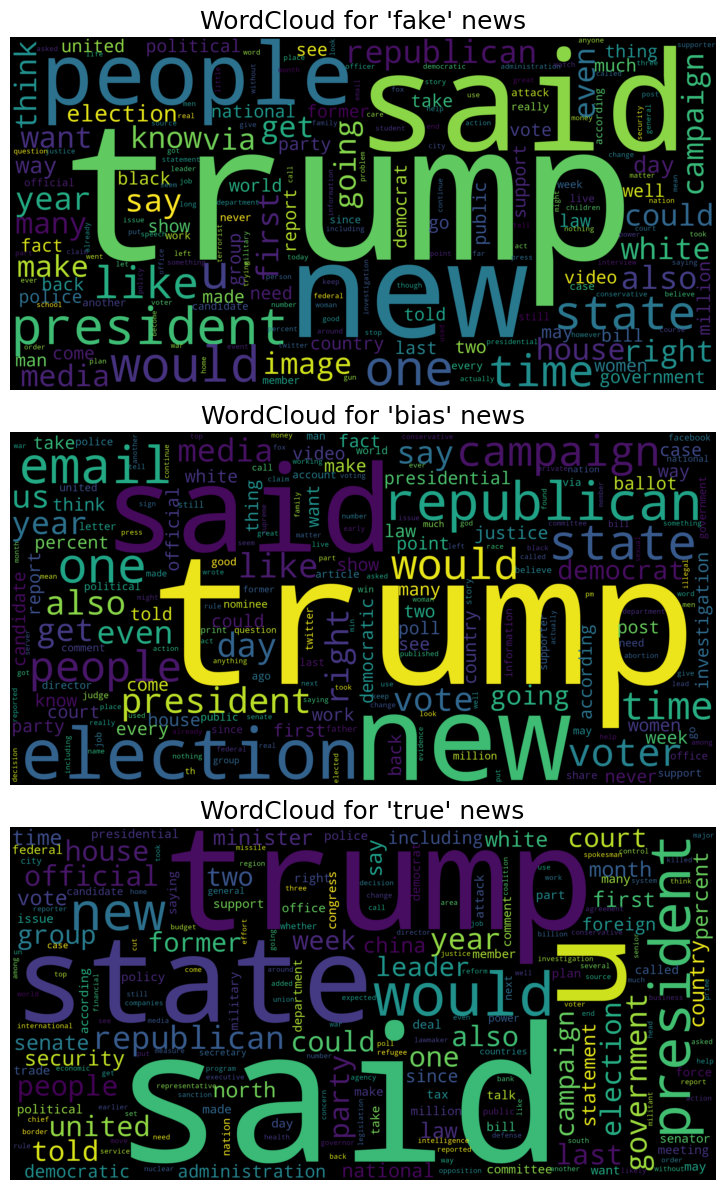

In [131]:
from wordcloud import WordCloud, STOPWORDS


# Create a subplot with 3 rows and 1 column, and set the figure size
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

# Word cloud for 'fake' news
corpus_text = ' '.join(df_news[df_news['type'] == 'fake']['clean_text'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale=7, collocations=False).generate(corpus_text)
ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title("WordCloud for 'fake' news", fontsize=18)

# Word cloud for 'bias' news
corpus_text = ' '.join(df_news[df_news['type'] == 'bias']['clean_text'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale=7, collocations=False).generate(corpus_text)
ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title("WordCloud for 'bias' news", fontsize=18)

# Word cloud for 'true' news
corpus_text = ' '.join(df_news[df_news['type'] == 'true']['clean_text'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale=7, collocations=False).generate(corpus_text)
ax[2].imshow(wordcloud, interpolation='bilinear')
ax[2].axis("off")
ax[2].set_title("WordCloud for 'true' news", fontsize=18)

# Adjust the layout of the plot
plt.tight_layout()
plt.show()


### - Stop words are common words like "the", "is", "in", etc., that are often ignored in text analysis because they appear frequently in all kinds of texts and generally do not carry important meaning.

use union add "would", "one", and "new"to the stopwords set


In [132]:
stop_words = STOPWORDS.union(set(["would", "one", "new"])) #Most common words in all

In [133]:
# most common 20 words in fake content
corpus_text = [preprocess_text(i).split() for i in df_news[df_news['type'] == 'fake']['clean_text'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words]
c = Counter(corpus_text)
most_common_fake_content = c.most_common(20)

# most common 20 words in true content
corpus_text = [preprocess_text(i).split() for i in df_news[df_news['type'] == 'true']['clean_text'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words]
c = Counter(corpus_text)
most_common_true_content = c.most_common(20)

# most common 20 words in bias content
corpus_text = [preprocess_text(i).split() for i in df_news[df_news['type'] == 'bias']['clean_text'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words]
c = Counter(corpus_text)
most_common_bias_content = c.most_common(20)

print('Fake news content - most common words:')
for word, count in most_common_fake_content:
    print(f'{word}: {count}')

print('\nTrue news content - most common words:')
for word, count in most_common_true_content:
    print(f'{word}: {count}')

print('\nBias news content - most common words:')
for word, count in most_common_bias_content:
    print(f'{word}: {count}')



Fake news content - most common words:
trump: 75260
said: 32009
people: 27208
president: 26165
us: 23204
news: 14562
even: 14494
time: 13426
state: 13195
white: 13119
media: 11579
via: 11322
campaign: 11079
house: 10859
know: 10700
first: 10498
many: 10325
going: 10146
states: 9906
image: 9676

True news content - most common words:
said: 99042
trump: 54268
us: 41154
president: 26454
state: 19766
government: 18317
states: 16630
house: 16548
united: 15574
republican: 15348
people: 15255
told: 14244
last: 12614
party: 12457
two: 11624
election: 11522
year: 11500
former: 10601
campaign: 10593
security: 10105

Bias news content - most common words:
trump: 1516
said: 491
election: 395
campaign: 338
people: 332
president: 257
republican: 228
voters: 226
news: 225
us: 221
media: 212
time: 207
even: 202
vote: 198
republicans: 194
state: 193
emails: 191
email: 190
going: 182
presidential: 175


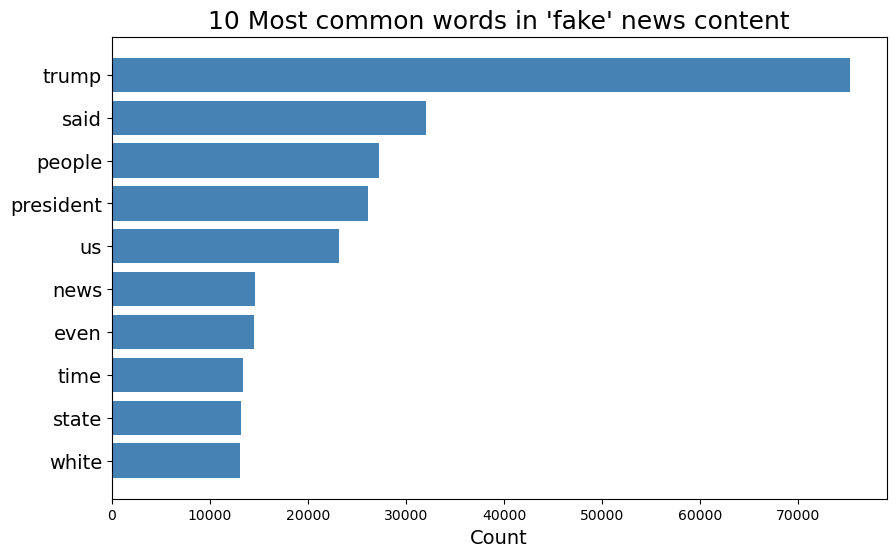

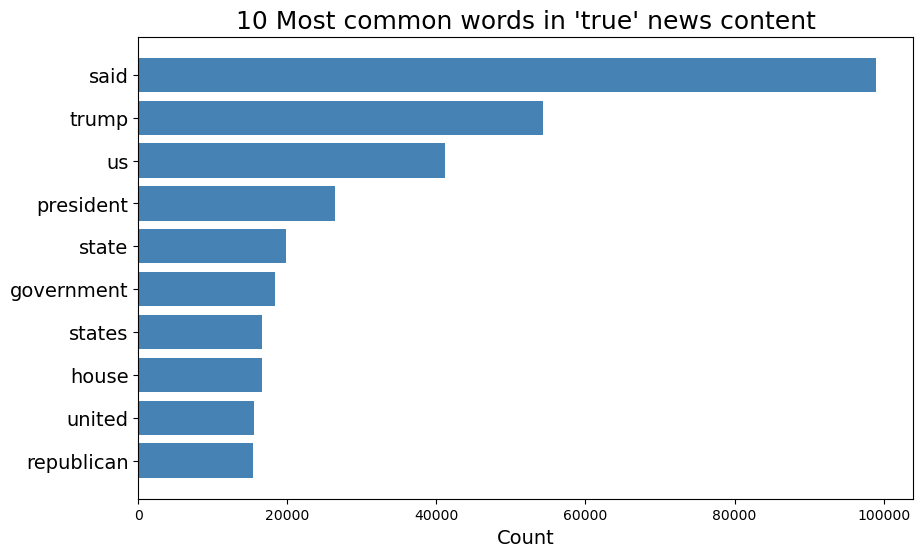

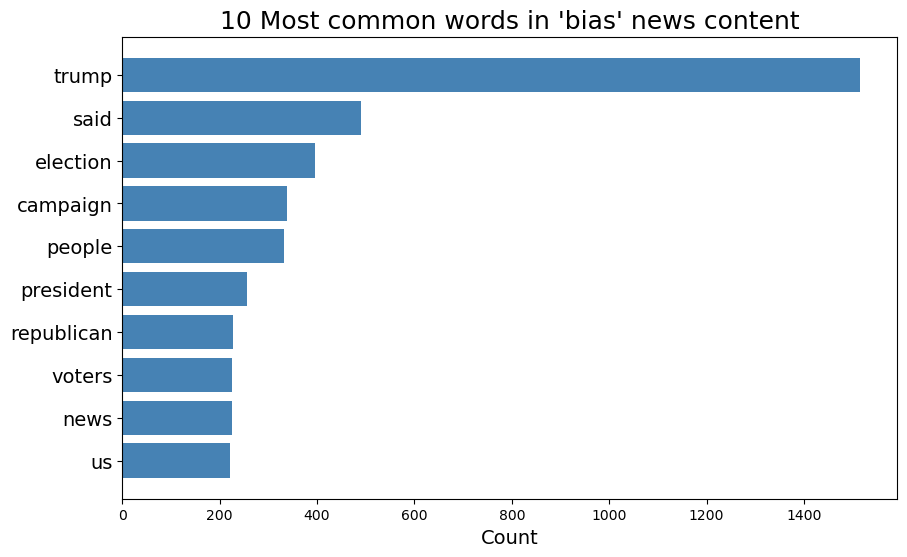

In [134]:
# Define titles and variables for each type of news content
names = ["10 Most common words in 'fake' news content", "10 Most common words in 'true' news content", "10 Most common words in 'bias' news content"]
variables = [most_common_fake_content, most_common_true_content, most_common_bias_content]

# Generate a chart for each type of news content
for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(10,6))

    words = [item[0] for item in var[:10]] # Extract the top 10 most common words
    counts = [item[1] for item in var[:10]] # Extract the counts of the top 10 most common words

    ax.barh(words, counts, color='steelblue') # Create a bar chart
    ax.invert_yaxis() # Invert the y-axis, so the most common word is on top
    plt.tick_params(axis='y', which='major', labelsize=14) # Set the y-axis tick size
    plt.title(title, fontsize=18) # Set the chart title and size
    plt.xlabel('Count', fontsize=14) # Set the x-axis label and size
    plt.show() # Display the chart

## WordCloud

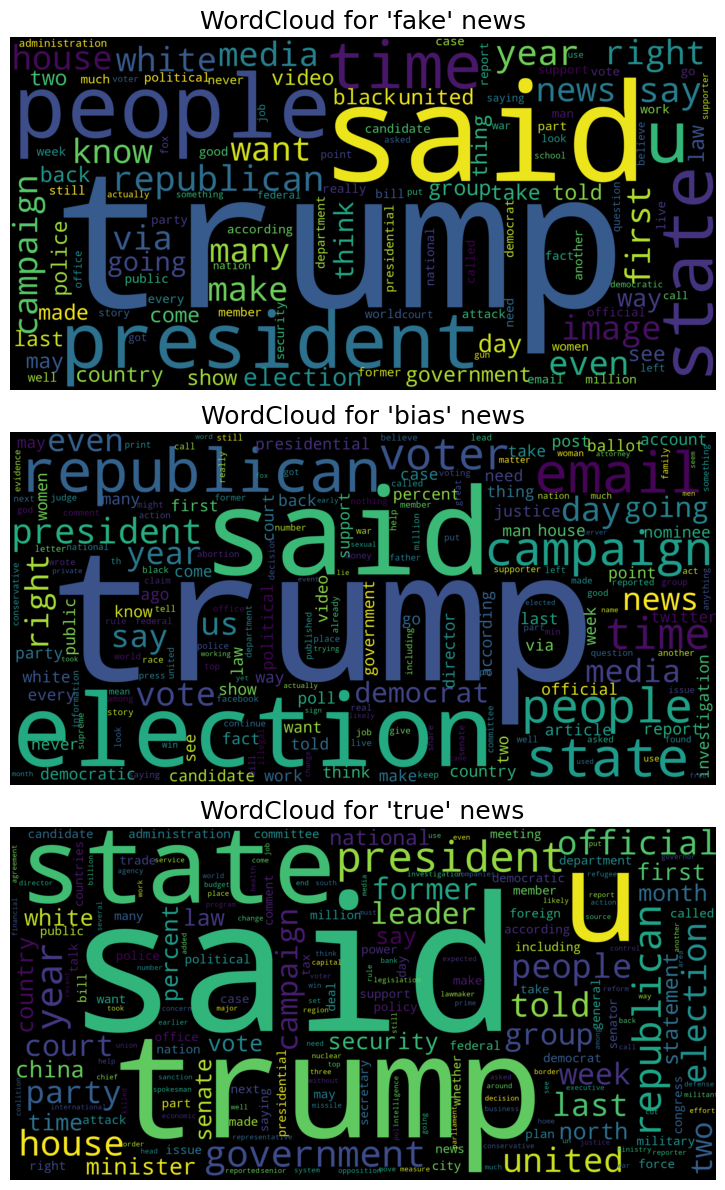

In [135]:

# Create a subplot with 3 rows and 1 column, and set the figure size
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

# Word cloud for 'fake' news
corpus_text = ' '.join(df_news[df_news['type'] == 'fake']['clean_text'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale=7, collocations=False).generate(corpus_text)
ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title("WordCloud for 'fake' news", fontsize=18)

# Word cloud for 'bias' news
corpus_text = ' '.join(df_news[df_news['type'] == 'bias']['clean_text'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale=7, collocations=False).generate(corpus_text)
ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title("WordCloud for 'bias' news", fontsize=18)

# Word cloud for 'true' news
corpus_text = ' '.join(df_news[df_news['type'] == 'true']['clean_text'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale=7, collocations=False).generate(corpus_text)
ax[2].imshow(wordcloud, interpolation='bilinear')
ax[2].axis("off")
ax[2].set_title("WordCloud for 'true' news", fontsize=18)

# Adjust the layout of the plot
plt.tight_layout()
plt.show()

# **Vectorization**

In [136]:
# Tokenize the 'clean_text' column using the loaded model
df_news["vectorized_clean_text"] = df_news.progress_apply(lambda r: [model.key_to_index[word]
                                                 for word in word_tokenize(str(r["clean_text"]))
                                                 if word in model.key_to_index], axis=1)

Pandas Apply:   0%|          | 0/46401 [00:00<?, ?it/s]

In [137]:
# Tokenize the 'title' column using the loaded model
df_news["vectorized_title"] = df_news.progress_apply(lambda r: [model.key_to_index[word]
                                                 for word in word_tokenize(str(r["title"]))
                                                 if word in model.key_to_index], axis=1)

Pandas Apply:   0%|          | 0/46401 [00:00<?, ?it/s]

In [138]:
df_news.head()

,title,text,type,clean_text,vectorized_clean_text,vectorized_title
0,busted stole millions gov benefits,Print They should pay all the back all the mon...,bias,print pay back money plus interest entire fami...,"[3472, 378, 95, 237, 1473, 558, 1107, 244, 890...","[15359, 5024, 1645, 35134, 1053]"
1,attorney general plead fifth,Why Did Attorney General Loretta Lynch Plead T...,bias,attorney general plead fifth brigade print adm...,"[1171, 580, 18193, 1038, 14184, 3472, 804, 590...","[1171, 580, 18193, 1038]"
2,breaking cooperating email investigation,Red State : \nFox News Sunday reported this mo...,bias,red state fox news reported morning cooperatin...,"[1618, 111, 27475, 303, 343, 565, 10807, 9402,...","[2329, 10807, 2227, 915]"
3,pin drop speech father daughter kidnapped kill...,Email Kayla Mueller was a prisoner and torture...,bias,email prisoner tortured chance horrific story ...,"[2227, 8424, 10653, 608, 10983, 550, 913, 573,...","[7648, 1223, 1682, 913, 1211, 7159, 496, 1817,..."
4,fantastic trumps point plan reform healthcare ...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,bias,email healthcare reform make great since march...,"[2227, 3104, 2130, 109, 267, 140, 5557, 68, 40...","[3903, 28624, 283, 326, 2130, 3104, 2219, 3387..."


In [139]:
# Filter out rows with empty titles
df_news = df_news[df_news["vectorized_title"].map(len) >= 1]

# Reset index
df_news = df_news.reset_index().drop("index", axis=1)

In [140]:
df_news

,title,text,type,clean_text,vectorized_clean_text,vectorized_title
0,busted stole millions gov benefits,Print They should pay all the back all the mon...,bias,print pay back money plus interest entire fami...,"[3472, 378, 95, 237, 1473, 558, 1107, 244, 890...","[15359, 5024, 1645, 35134, 1053]"
1,attorney general plead fifth,Why Did Attorney General Loretta Lynch Plead T...,bias,attorney general plead fifth brigade print adm...,"[1171, 580, 18193, 1038, 14184, 3472, 804, 590...","[1171, 580, 18193, 1038]"
2,breaking cooperating email investigation,Red State : \nFox News Sunday reported this mo...,bias,red state fox news reported morning cooperatin...,"[1618, 111, 27475, 303, 343, 565, 10807, 9402,...","[2329, 10807, 2227, 915]"
3,pin drop speech father daughter kidnapped kill...,Email Kayla Mueller was a prisoner and torture...,bias,email prisoner tortured chance horrific story ...,"[2227, 8424, 10653, 608, 10983, 550, 913, 573,...","[7648, 1223, 1682, 913, 1211, 7159, 496, 1817,..."
4,fantastic trumps point plan reform healthcare ...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,bias,email healthcare reform make great since march...,"[2227, 3104, 2130, 109, 267, 140, 5557, 68, 40...","[3903, 28624, 283, 326, 2130, 3104, 2219, 3387..."
...,...,...,...,...,...,...
46269,fully committed backs new us approach,BRUSSELS (Reuters) - NATO allies on Tuesday we...,true,allies welcomed president trump decision commi...,"[4071, 4111, 348, 25752, 402, 4646, 937, 186, ...","[1573, 1515, 4454, 65, 164, 1247]"
46270,withdrew two products market,"LONDON (Reuters) - LexisNexis, a provider of l...",true,provider legal regulatory business information...,"[1710, 885, 3147, 160, 181, 9, 8044, 54, 384, ...","[7486, 54, 384, 175]"
46271,cultural hub becomes authorities,MINSK (Reuters) - In the shadow of disused Sov...,true,shadow factories street lined eclectic bars ar...,"[8060, 6992, 1482, 4971, 19529, 5023, 1451, 15...","[3189, 6468, 2540, 892]"
46272,upbeat possibility pope visiting,MOSCOW (Reuters) - Vatican Secretary of State ...,true,secretary state cardinal said positive momentu...,"[2175, 111, 23955, 9, 1057, 3089, 474, 931, 80...","[7998, 2139, 8000, 2509]"


In [141]:
def pad_array(array, token_len):
    '''
    Parameters:
        array: The input array that needs to be padded or truncated.
        token_len: The desired length of the array after padding or truncation.
    Return value:
        The function returns the padded or truncated array.
    '''
    diff_token = token_len - len(array)
    if diff_token < 0:
        array = array[:token_len]  # Truncate
    else:
        # Pad
        array += [0] * diff_token  # Pad

    return array

Pandas Apply:   0%|          | 0/46274 [00:00<?, ?it/s]

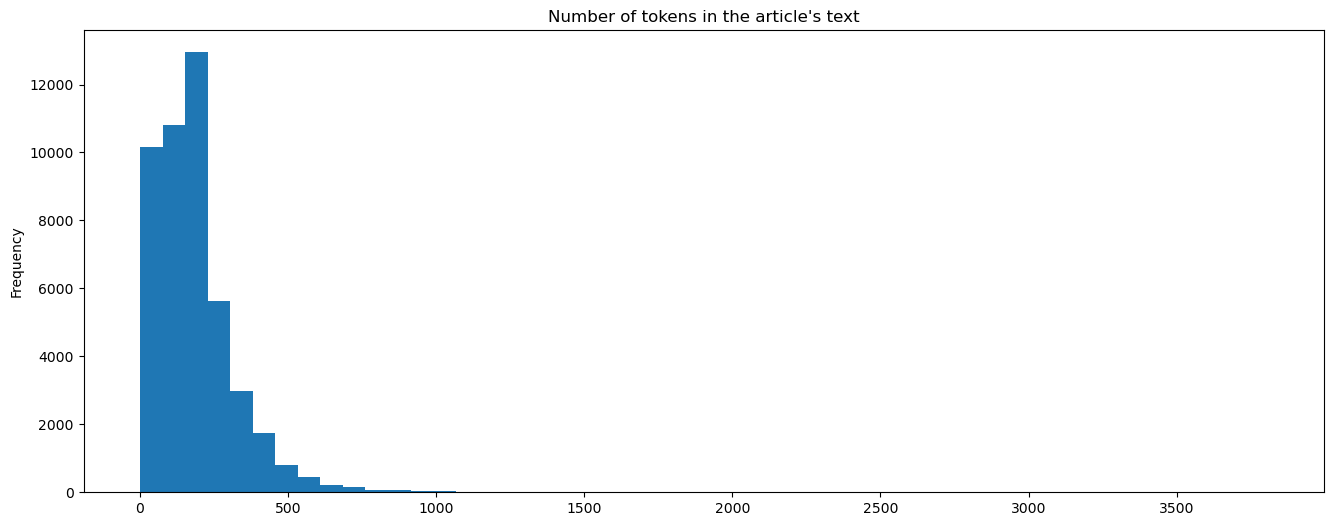

In [142]:
tokens_numbers = df_news.swifter.apply(lambda row: len(row["vectorized_clean_text"]), axis = 1)

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
tokens_numbers.plot.hist(title="Number of tokens in the article's text", bins=50, ax=ax)
plt.show()

In [143]:
print("Mean number of tokens per article: {}".format(int(np.mean(tokens_numbers))))
print("Standard deviation of tokens per article: {}".format(int(np.std(tokens_numbers))))
print("Median of tokens per article: {}".format(int(np.median(tokens_numbers))))


Mean number of tokens per article: 187
Standard deviation of tokens per article: 167
Median of tokens per article: 164


In [144]:
max_tokens = int(np.mean(tokens_numbers) + 2 * np.std(tokens_numbers))

percent_tokens = df_news[df_news["vectorized_clean_text"].apply(len) <= max_tokens].shape[0] / df_news.shape[0]
print("Chosen token window: {} - Covers {}% of the dataset".format(max_tokens, percent_tokens * 100))

Chosen token window: 523 - Covers 97.24035095301898% of the dataset


Chosen token window: 523

This indicates that the maximum number of tokens considered for each article is set to 523. The token window size represents the desired length for the sequences in the 'content' column after padding or truncation.

Covers 97.24035095301898% of the dataset

This percentage indicates the proportion of articles in the dataset that have a token count less than or equal to the chosen token window size. In this case, approximately 97.24% of the articles fall within the specified token window size of 523.

In [145]:
max_len_text = max_tokens
df_news["vectorized_clean_text"] = df_news.apply(lambda r: pad_array(r["vectorized_clean_text"], max_len_text) , axis=1)

Do the same for the title

Pandas Apply:   0%|          | 0/46274 [00:00<?, ?it/s]

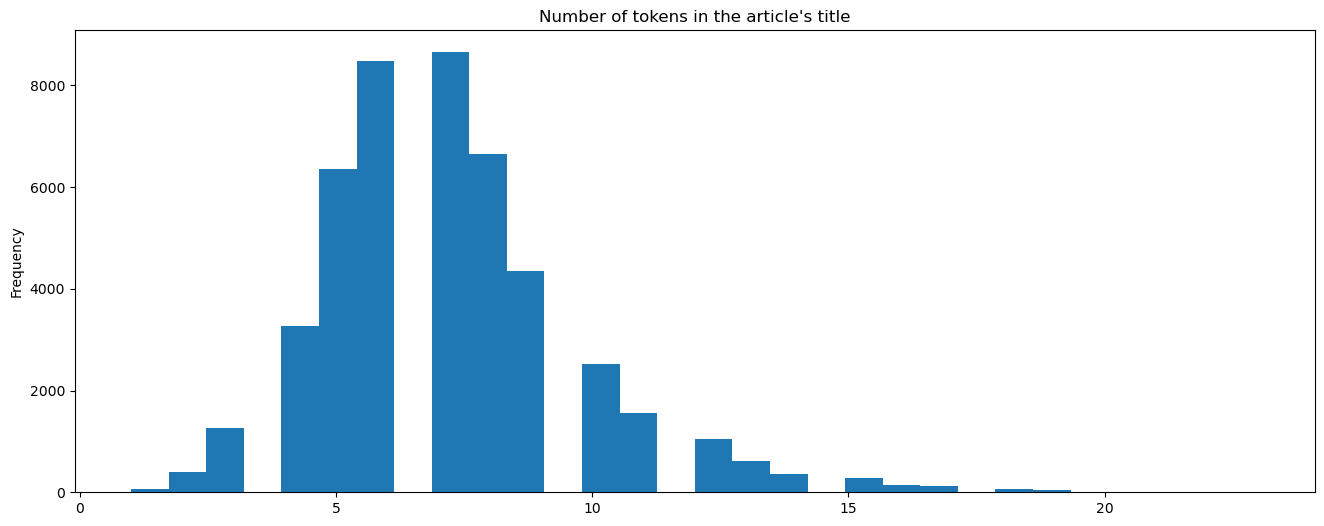

In [146]:
tokens_numbers = df_news.swifter.apply(lambda row: len(row["vectorized_title"]), axis = 1)

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
tokens_numbers.plot.hist(title="Number of tokens in the article's title", bins=30, ax=ax)
plt.show()

In [147]:
print("Mean number of tokens in the title per article: {}".format(int(np.mean(tokens_numbers))))
print("Standard deviation of tokens in the title per article: {}".format(int(np.std(tokens_numbers))))
print("Median of tokens in the title per article: {}".format(int(np.median(tokens_numbers))))
max_tokens = int(np.mean(tokens_numbers) + 2 * np.std(tokens_numbers))

percent_tokens = df_news[df_news["vectorized_title"].apply(len) <= max_tokens].shape[0] / df_news.shape[0]
print("Chosen token window: {} - Covers {}% of the dataset".format(max_tokens, percent_tokens * 100))

Mean number of tokens in the title per article: 7
Standard deviation of tokens in the title per article: 2
Median of tokens in the title per article: 7
Chosen token window: 12 - Covers 96.4515710766305% of the dataset


In [148]:
max_len_title = max_tokens
df_news["vectorized_title"] = df_news.apply(lambda r: pad_array(r["vectorized_title"], max_len_title) , axis=1)

# **Classify the type's Label by One-hot encoding**

In [149]:
encoder = LabelBinarizer().fit(list(df_news["type"]))
df_news["one_hot_label"] = df_news.apply(lambda r: encoder.transform([r['type']])[0], axis=1)
df_news.head()

,title,text,type,clean_text,vectorized_clean_text,vectorized_title,one_hot_label
0,busted stole millions gov benefits,Print They should pay all the back all the mon...,bias,print pay back money plus interest entire fami...,"[3472, 378, 95, 237, 1473, 558, 1107, 244, 890...","[15359, 5024, 1645, 35134, 1053, 0, 0, 0, 0, 0...","[1, 0, 0]"
1,attorney general plead fifth,Why Did Attorney General Loretta Lynch Plead T...,bias,attorney general plead fifth brigade print adm...,"[1171, 580, 18193, 1038, 14184, 3472, 804, 590...","[1171, 580, 18193, 1038, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]"
2,breaking cooperating email investigation,Red State : \nFox News Sunday reported this mo...,bias,red state fox news reported morning cooperatin...,"[1618, 111, 27475, 303, 343, 565, 10807, 9402,...","[2329, 10807, 2227, 915, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]"
3,pin drop speech father daughter kidnapped kill...,Email Kayla Mueller was a prisoner and torture...,bias,email prisoner tortured chance horrific story ...,"[2227, 8424, 10653, 608, 10983, 550, 913, 573,...","[7648, 1223, 1682, 913, 1211, 7159, 496, 1817,...","[1, 0, 0]"
4,fantastic trumps point plan reform healthcare ...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,bias,email healthcare reform make great since march...,"[2227, 3104, 2130, 109, 267, 140, 5557, 68, 40...","[3903, 28624, 283, 326, 2130, 3104, 2219, 3387...","[1, 0, 0]"


In [150]:
print("LABELS")
enc = encoder.transform(encoder.classes_)
for x, y in zip(encoder.classes_, enc):
    print(x, y)

LABELS
bias [1 0 0]
fake [0 1 0]
true [0 0 1]


In [152]:
df_news.to_csv("/Users/tongzhaoliu/Desktop/fake news project/clean_news.csv", encoding='utf-8', index=False)


In [153]:
df_news.to_pickle("/Users/tongzhaoliu/Desktop/fake news project/clean_news.pickle")

In [154]:
df_news["type"].value_counts()

fake    24505
true    21417
bias      352
Name: type, dtype: int64

In [155]:
label_counts = df_news['one_hot_label'].apply(tuple).value_counts()
print(label_counts)


(0, 1, 0)    24505
(0, 0, 1)    21417
(1, 0, 0)      352
Name: one_hot_label, dtype: int64


In [156]:
len_text = len(df_news["vectorized_clean_text"][1000])
len_title = len(df_news['vectorized_title'][1000])

print("Max len content: {}".format(len_text))
print("Max len title: {}".format(len_title))

Max len content: 523
Max len title: 12
